AFTER SCANDALS


=== AMD (after) ===
Obs Low: 213 | Obs High: 211 | Threshold≈ 0.021

[Low regime] lag = 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     22:14:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.128033
Nobs:                     212.000    HQIC:                 -0.184635
Log likelihood:          -571.989    FPE:                   0.800093
AIC:                    -0.223031    Det(Omega_mle):        0.777921
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.007275         0.064417            0.113           0.910
L1.ret           0.046223         0.068907            0.671        

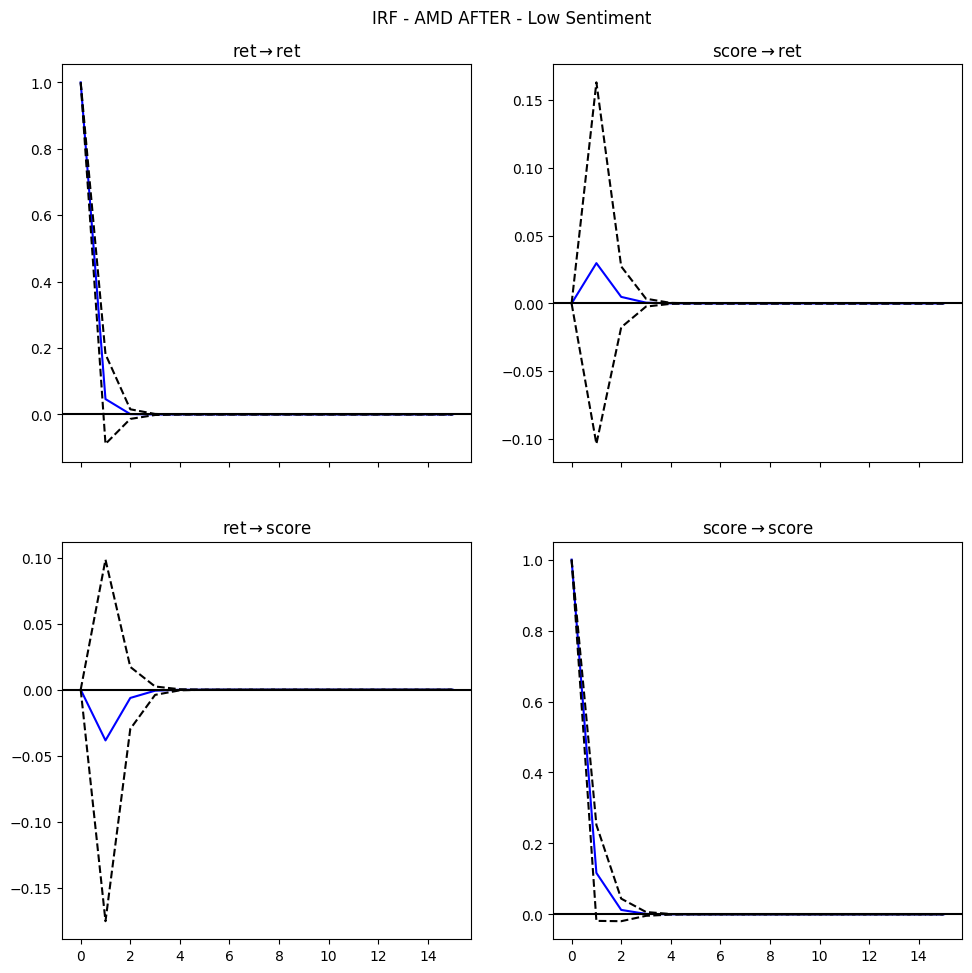

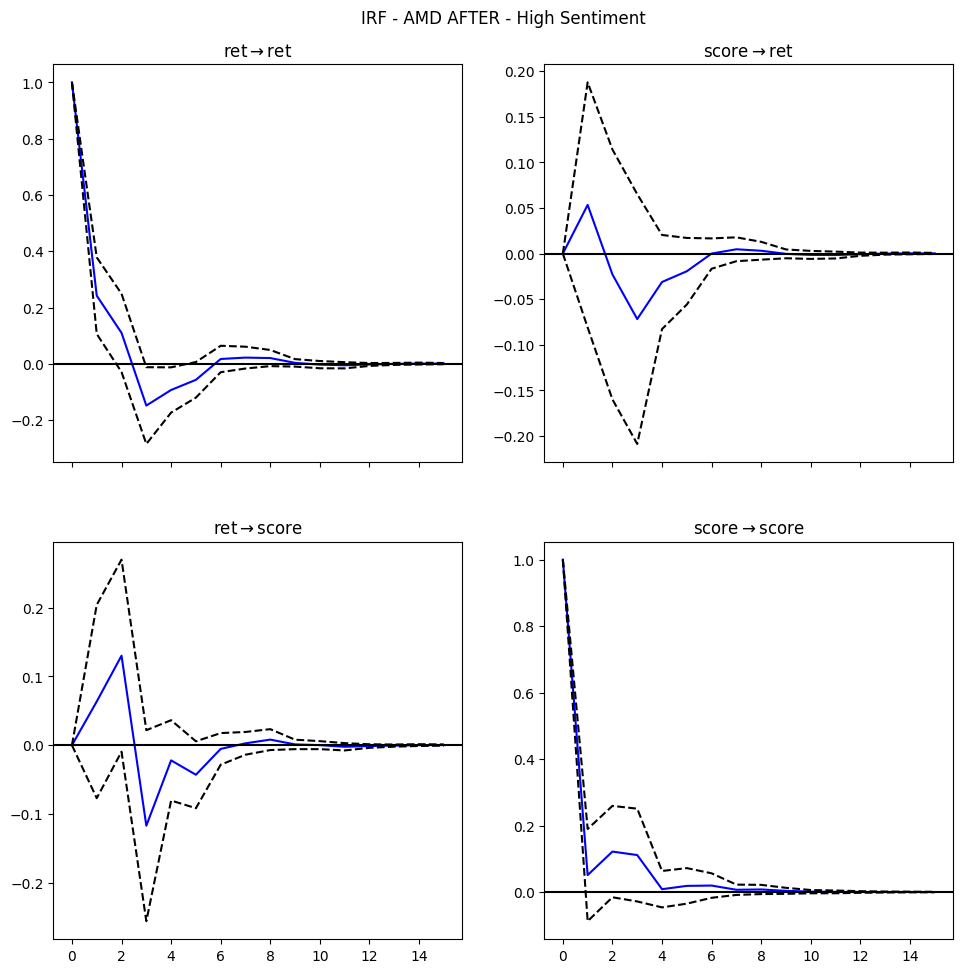


=== ART (after) ===
Obs Low: 212 | Obs High: 210 | Threshold≈ 0.031

[Low regime] lag = 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     22:14:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.277642
Nobs:                     210.000    HQIC:                 -0.372594
Log likelihood:          -540.066    FPE:                   0.645965
AIC:                    -0.437028    Det(Omega_mle):        0.616270
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.075389         0.058172            1.296           0.195
L1.ret           0.020474         0.065795            0.311        

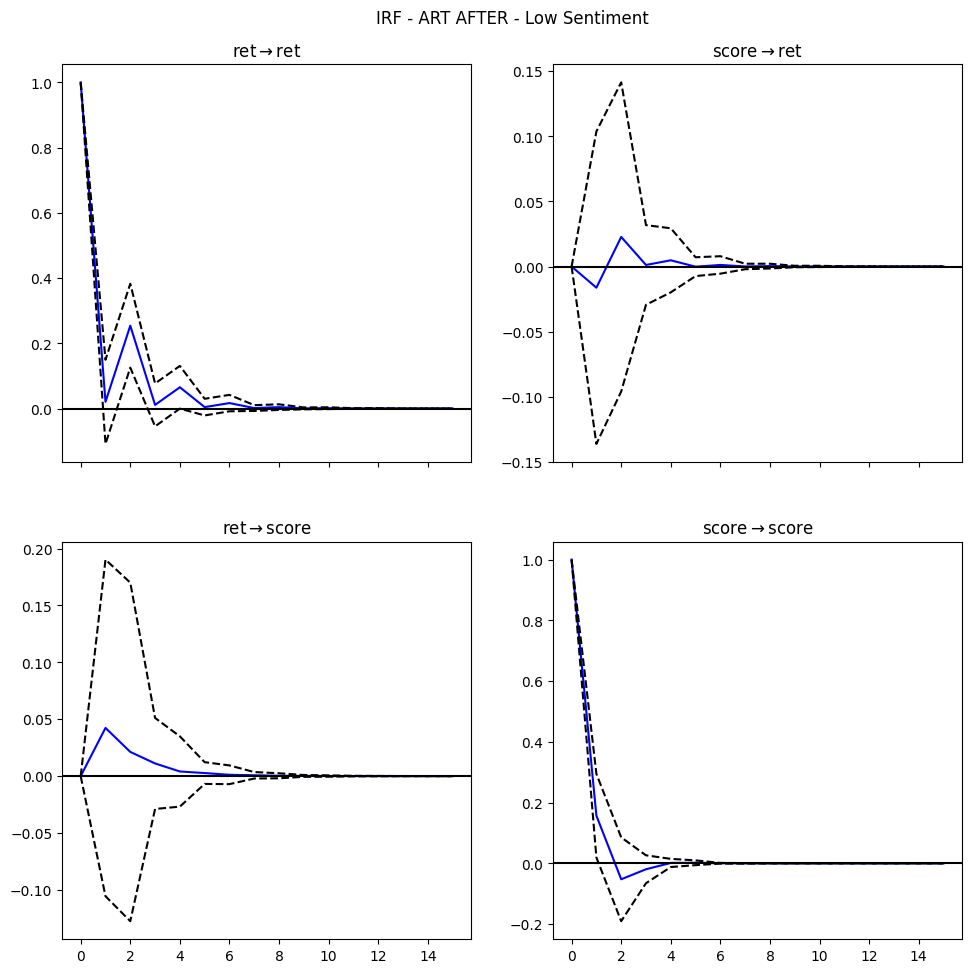

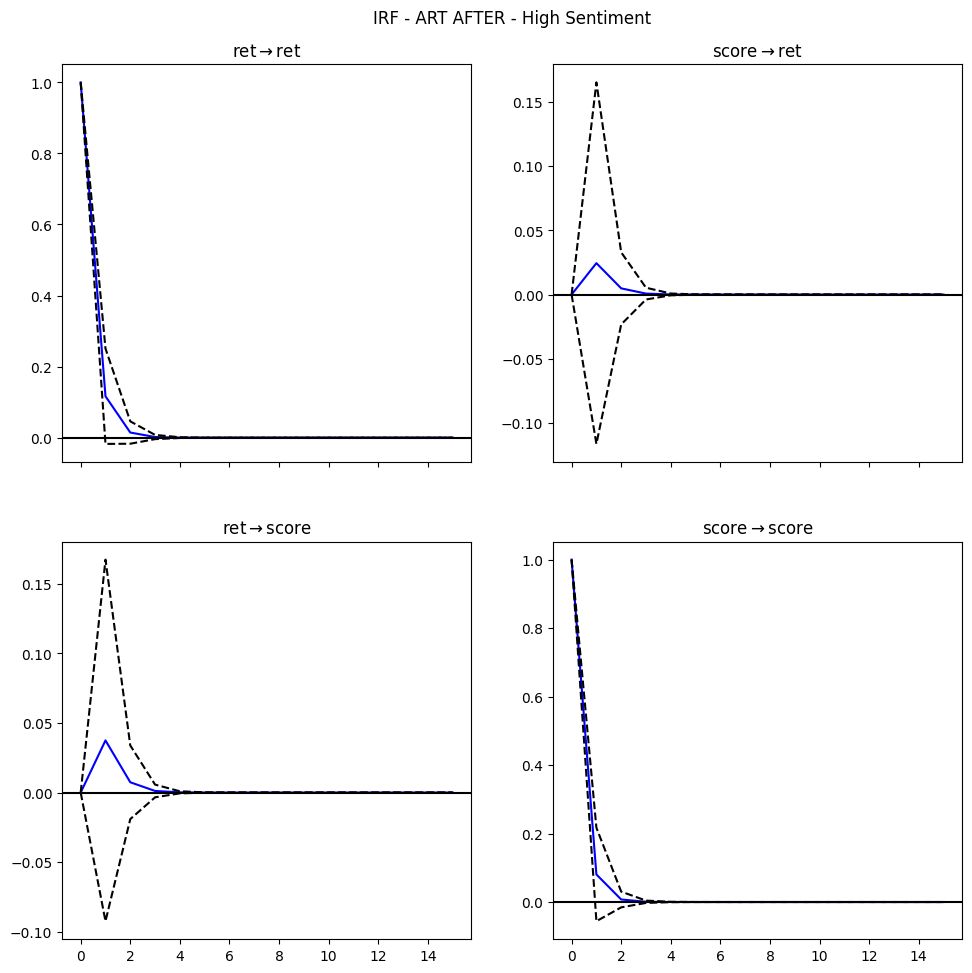


=== FLC (after) ===
Obs Low: 212 | Obs High: 211 | Threshold≈ 0.029

[Low regime] lag = 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     22:14:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.142663
Nobs:                     208.000    HQIC:                 -0.314702
Log likelihood:          -527.404    FPE:                   0.649612
AIC:                    -0.431488    Det(Omega_mle):        0.596845
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.038628         0.057899            0.667           0.505
L1.ret           0.026845         0.068386            0.393        

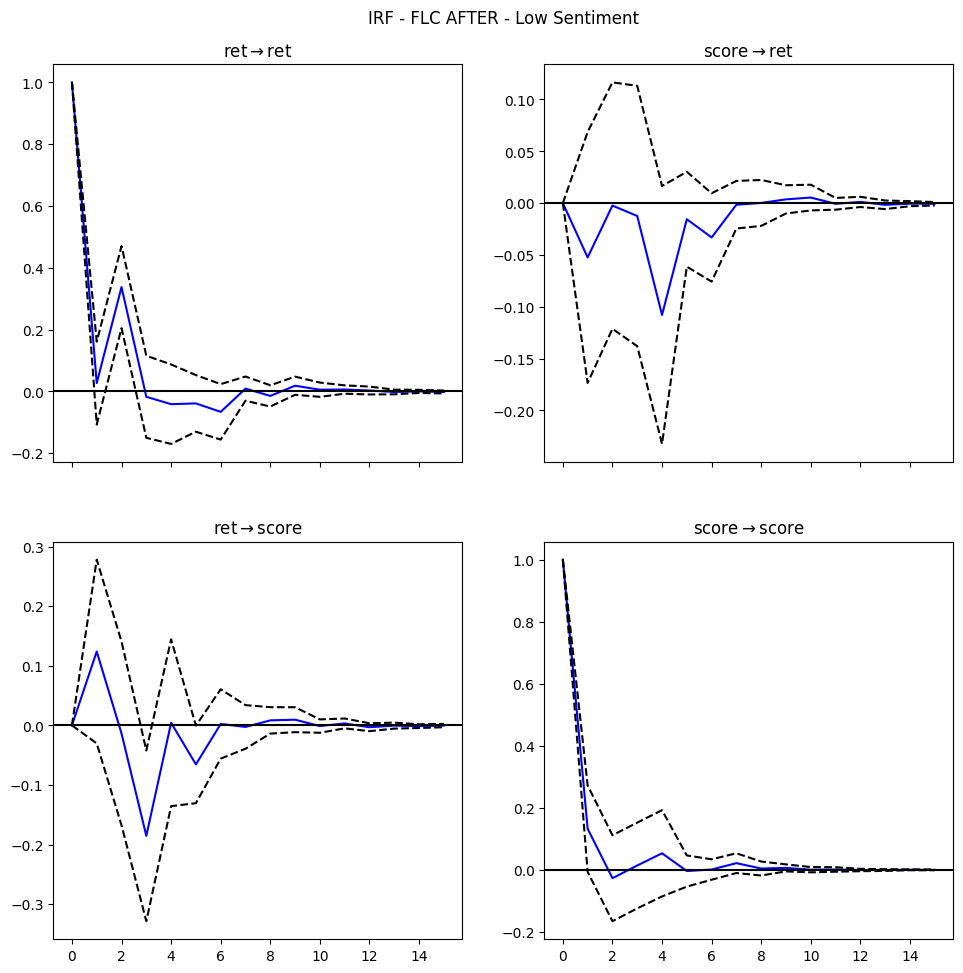

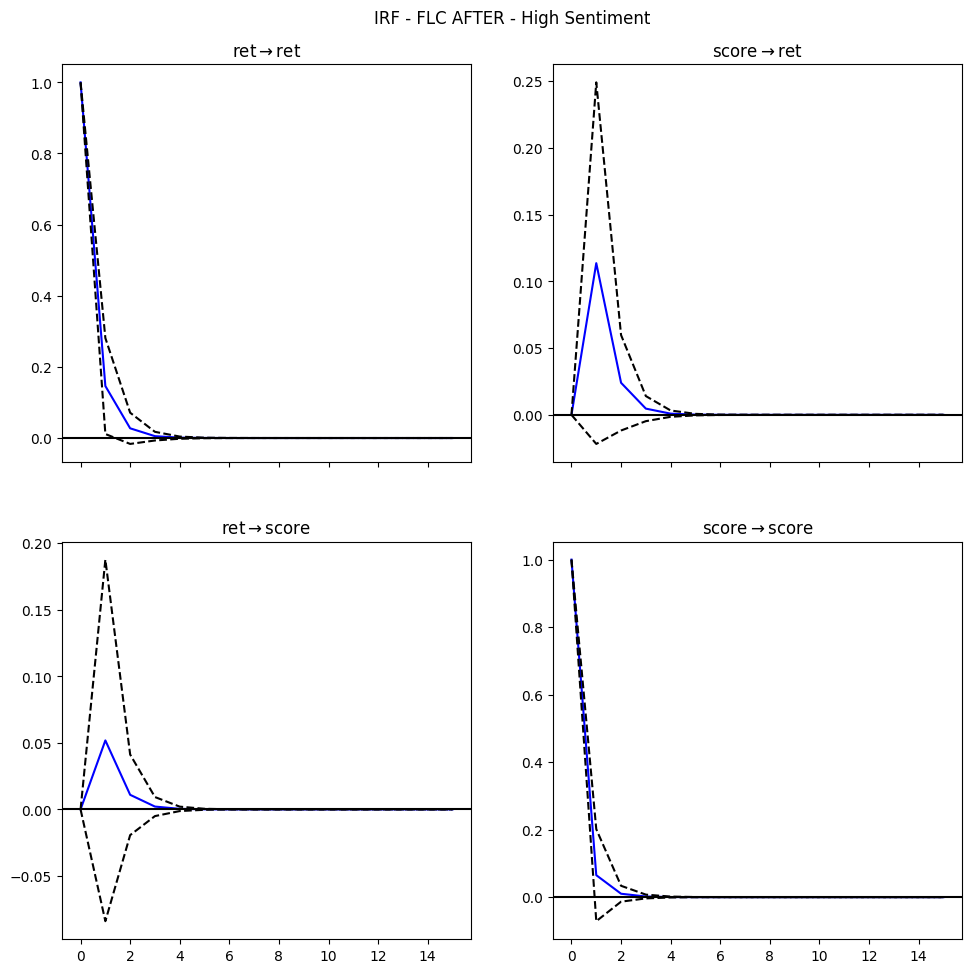


=== GAB (after) ===
Obs Low: 0 | Obs High: 0 | Threshold≈ 0.021
Low regime failed: zero-size array to reduction operation maximum which has no identity
High regime failed: zero-size array to reduction operation maximum which has no identity

=== HAI (after) ===
Obs Low: 213 | Obs High: 212 | Threshold≈ 0.032

[Low regime] lag = 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     22:14:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.417017
Nobs:                     210.000    HQIC:                 -0.549951
Log likelihood:          -514.738    FPE:                   0.527235
AIC:                    -0.640158    Det(Omega_mle):        0.493769
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           

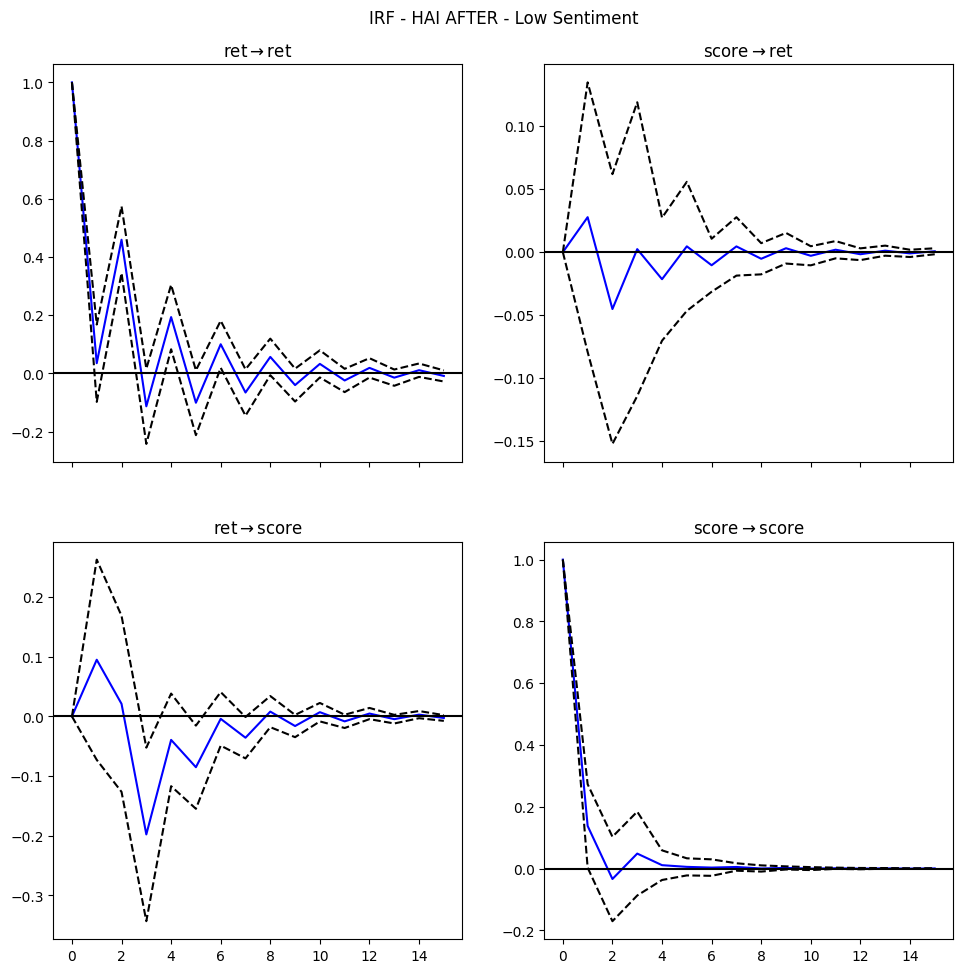

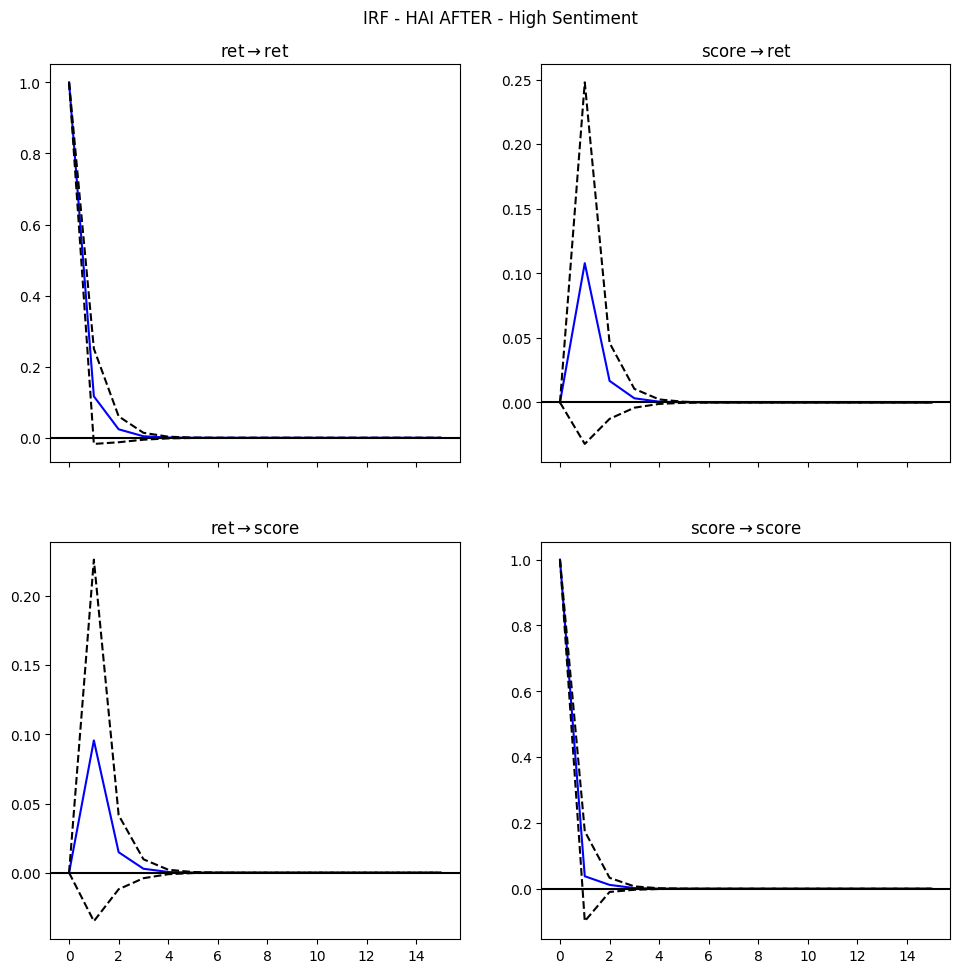

In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# -------- config ----------
folder_after = r"D:/NCKH/vnecon_after_scandals"
out_dir = os.path.join(folder_after, "_results_after")
os.makedirs(out_dir, exist_ok=True)

def zscore(df):
    return (df - df.mean()) / df.std(ddof=0)

def pick_lag(endog, maxcaps=4):
    n = len(endog)
    maxlags = min(maxcaps, max(1, n // 25))  # n≈200 -> max 4
    try:
        sel = VAR(endog).select_order(maxlags)
        lag = sel.selected_orders.get("aic") or 1
    except Exception:
        lag = 1
    return int(max(1, min(lag, maxlags)))

def fit_var(endog):
    # bỏ regime nếu biến gần hằng số
    if (endog.var() < 1e-10).any():
        raise ValueError("Near-constant series; skip.")
    p = pick_lag(endog)
    try:
        return VAR(endog).fit(p)
    except np.linalg.LinAlgError:
        # jitter phá suy biến
        jitter = endog + np.random.normal(scale=1e-6, size=endog.shape)
        return VAR(jitter).fit(p)

def plot_irf_save(irf, title, save_path, orth=False):
    fig = irf.plot(orth=orth)   # trả về Figure
    plt.suptitle(title)
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def run_after(path, ticker):
    df = pd.read_excel(path).sort_values("date")

    # return & continuous score
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["ret"]   = np.log(df["close"].replace(0, np.nan)).diff() # = ln(C_t) - ln(C_{t-1}) = ln(C_t / C_{t-1})
    df["score"] = pd.to_numeric(df.get("Tích cực"), errors="coerce") \
                - pd.to_numeric(df.get("Tiêu cực"), errors="coerce")


    data = df[["ret","score"]].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) < 30:
        print(f"{ticker}: observations too small ({len(data)}). Skipped.")
        return

    Z = zscore(data)
    thr = Z["score"].median()
    low  = Z[Z["score"].shift(1) <= thr].dropna()
    high = Z[Z["score"].shift(1) >  thr].dropna()

    print(f"\n=== {ticker} (after) ===")
    print(f"Obs Low: {len(low)} | Obs High: {len(high)} | Threshold≈{thr: .3f}")

    # fit từng regime
    res_low = res_high = None
    try:
        low = low.reset_index(drop=True)
        high = high.reset_index(drop=True)
        res_low = fit_var(low)
        print("\n[Low regime] lag =", res_low.k_ar)
        print(res_low.summary())
    except Exception as e:
        print("Low regime failed:", e)

    try:
        res_high = fit_var(high)
        print("\n[High regime] lag =", res_high.k_ar)
        print(res_high.summary())
    except Exception as e:
        print("High regime failed:", e)

    # IRF (orth=False để không cần Cholesky PD)
    if res_low is not None:
        try:
            irf_l = res_low.irf(15)
            plot_irf_save(
                irf_l,
                f"IRF - {ticker} AFTER - Low Sentiment",
                os.path.join(out_dir, f"{ticker}_AFTER_IRF_low.png"),
                orth=False
            )
        except Exception as e:
            print("IRF Low failed:", e)

    if res_high is not None:
        try:
            irf_h = res_high.irf(15)
            plot_irf_save(
                irf_h,
                f"IRF - {ticker} AFTER - High Sentiment",
                os.path.join(out_dir, f"{ticker}_AFTER_IRF_high.png"),
                orth=False
            )
        except Exception as e:
            print("IRF High failed:", e)

# -------- run all after files ----------
files = glob.glob(os.path.join(folder_after, "*.xlsx"))
if not files:
    print("Không thấy .xlsx trong:", folder_after)

for f in files:
    ticker = os.path.splitext(os.path.basename(f))[0]
    run_after(f, ticker)


BEFORE SCANDALS


=== AMD (before) ===
Obs Low: 528 | Obs High: 507 | Threshold≈-0.203

[Low regime] lag = 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     17:14:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.224288
Nobs:                     524.000    HQIC:                 -0.313349
Log likelihood:          -1371.93    FPE:                   0.690273
AIC:                    -0.370676    Det(Omega_mle):        0.667158
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.023778         0.046572            0.511           0.610
L1.ret           0.095104         0.043848            2.169       

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib

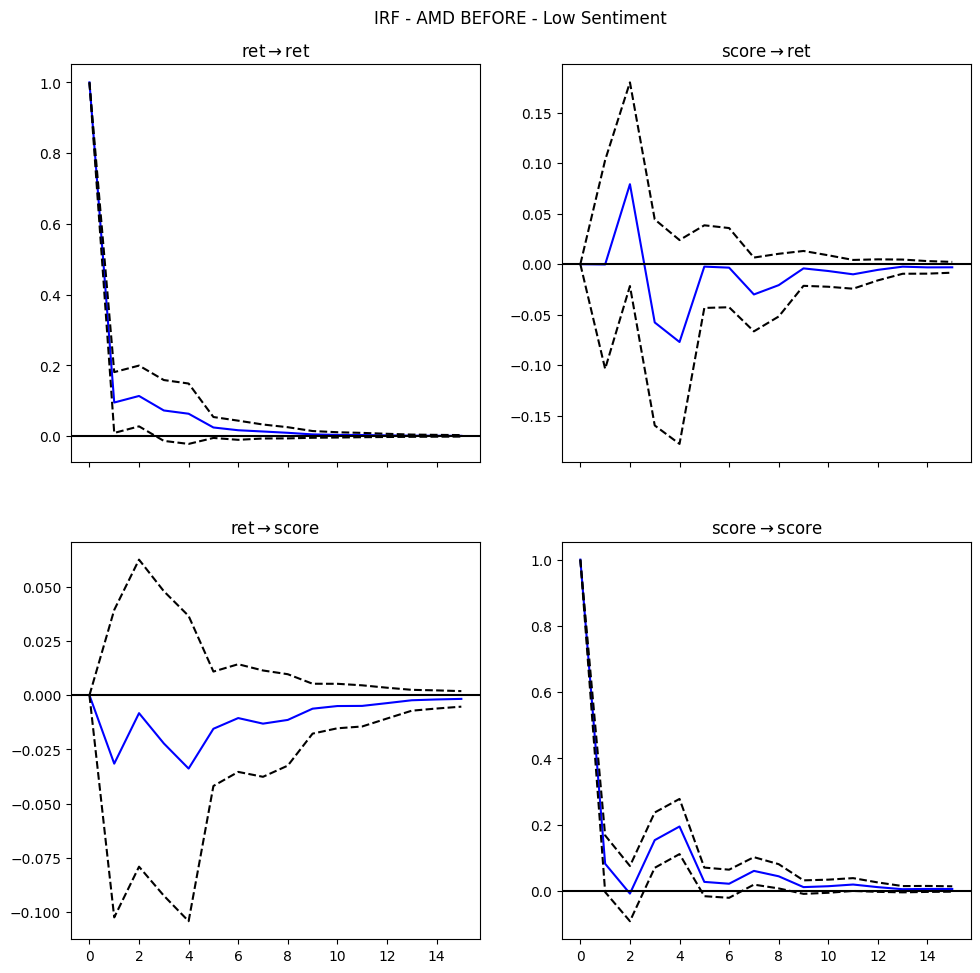

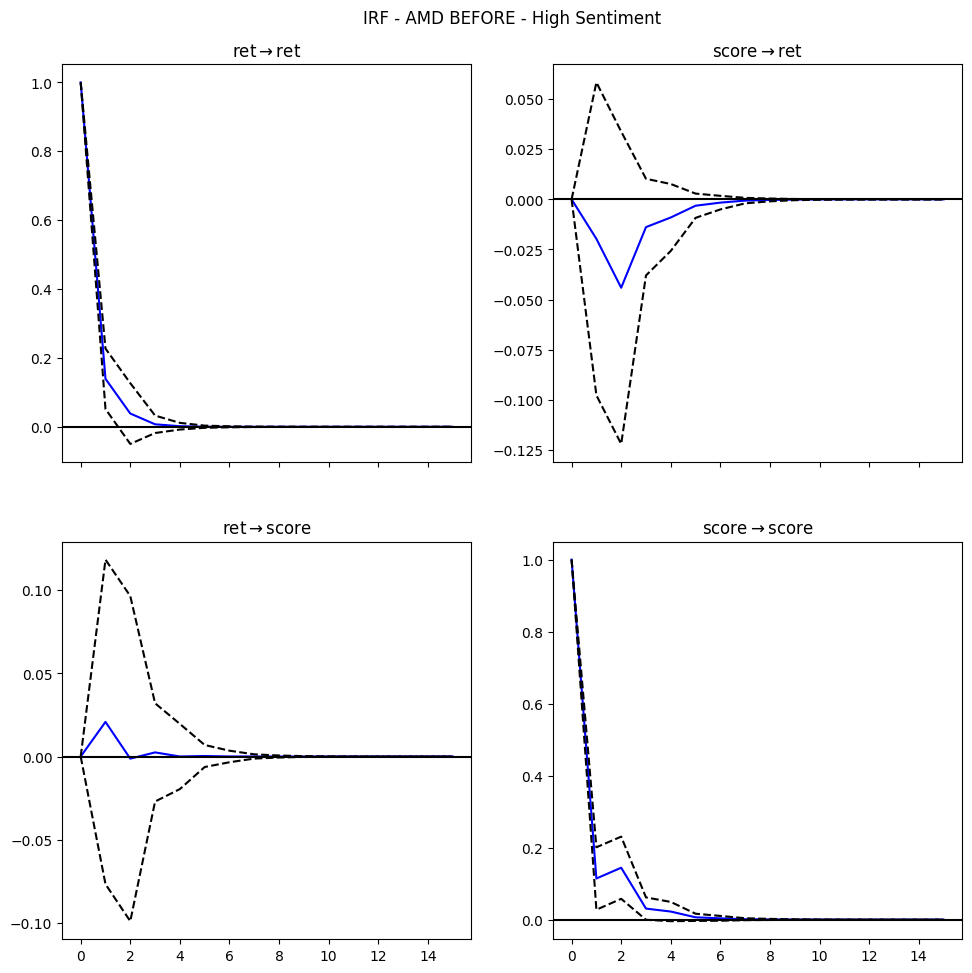


=== ART (before) ===
Obs Low: 526 | Obs High: 504 | Threshold≈-0.202

[Low regime] lag = 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     17:15:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.205197
Nobs:                     522.000    HQIC:                 -0.294509
Log likelihood:          -1371.50    FPE:                   0.703276
AIC:                    -0.352013    Det(Omega_mle):        0.679638
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.013768         0.047351            0.291           0.771
L1.ret          -0.027600         0.043839           -0.630       

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib

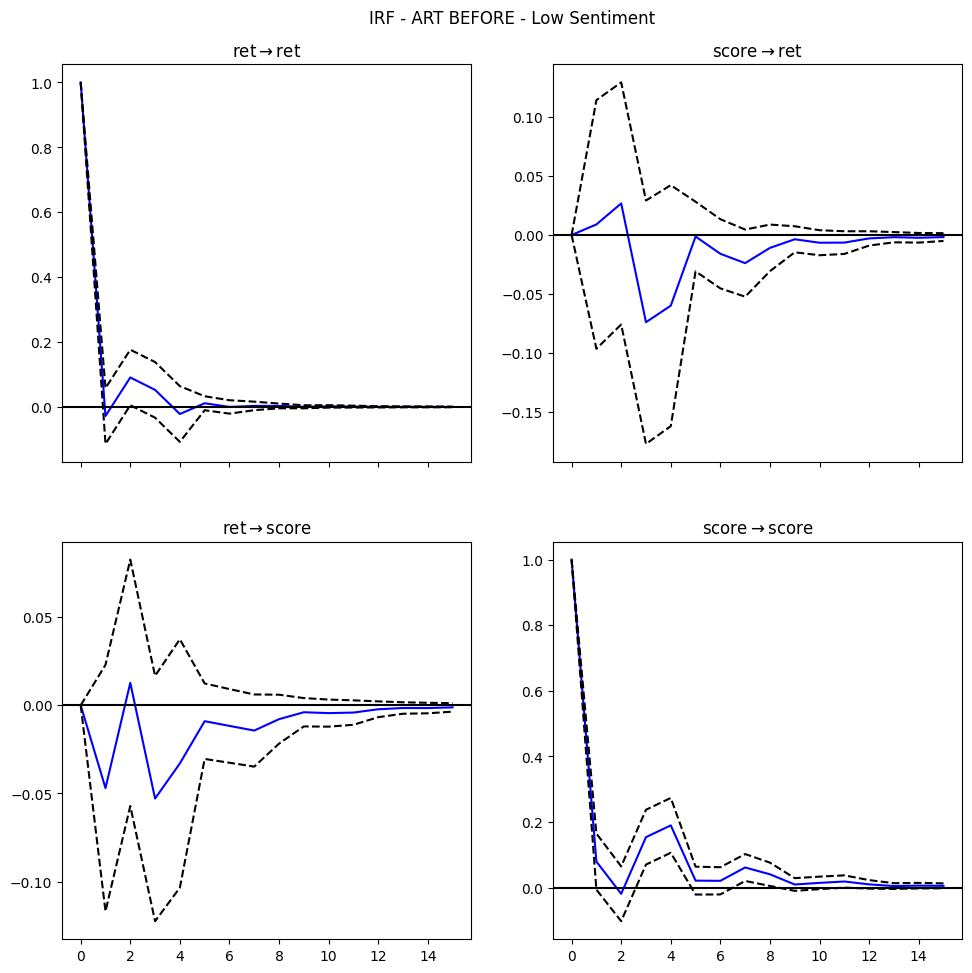

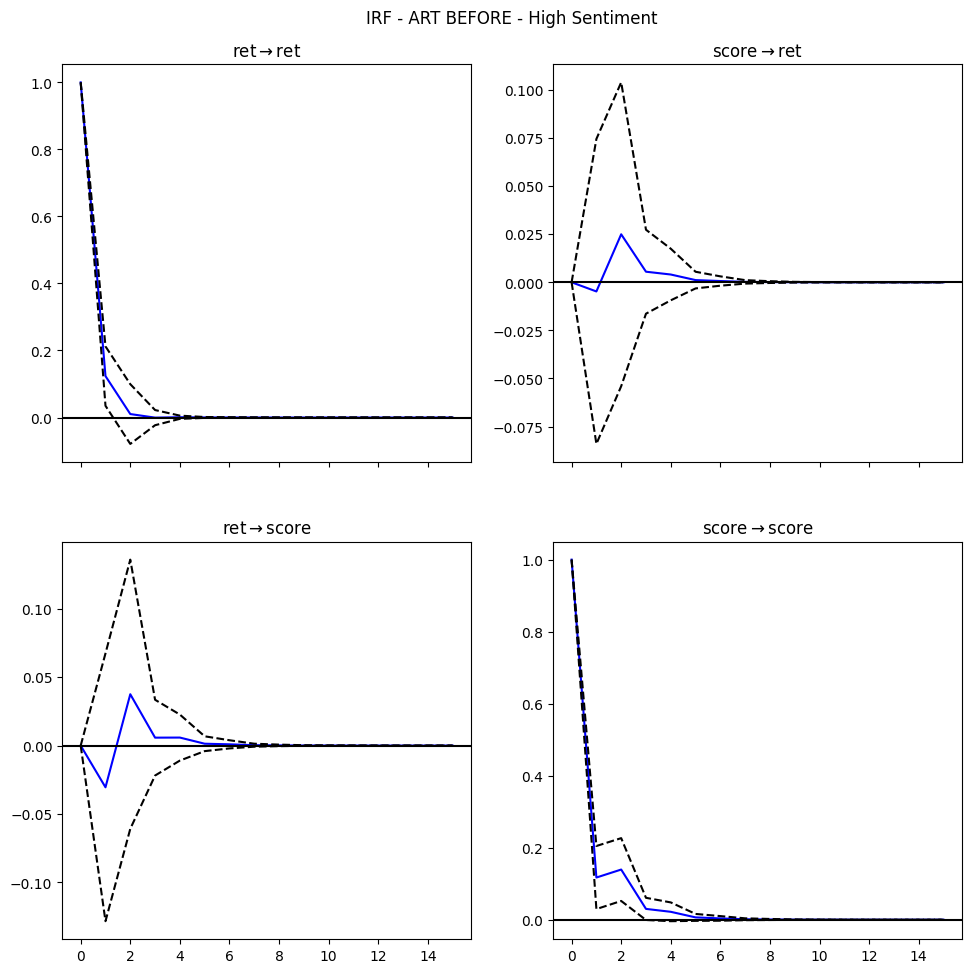


=== FLC (before) ===
Obs Low: 528 | Obs High: 507 | Threshold≈-0.203

[Low regime] lag = 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     17:15:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.155811
Nobs:                     524.000    HQIC:                 -0.244871
Log likelihood:          -1389.87    FPE:                   0.739197
AIC:                    -0.302198    Det(Omega_mle):        0.714444
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.033743         0.048041            0.702           0.482
L1.ret           0.037716         0.043916            0.859       

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib

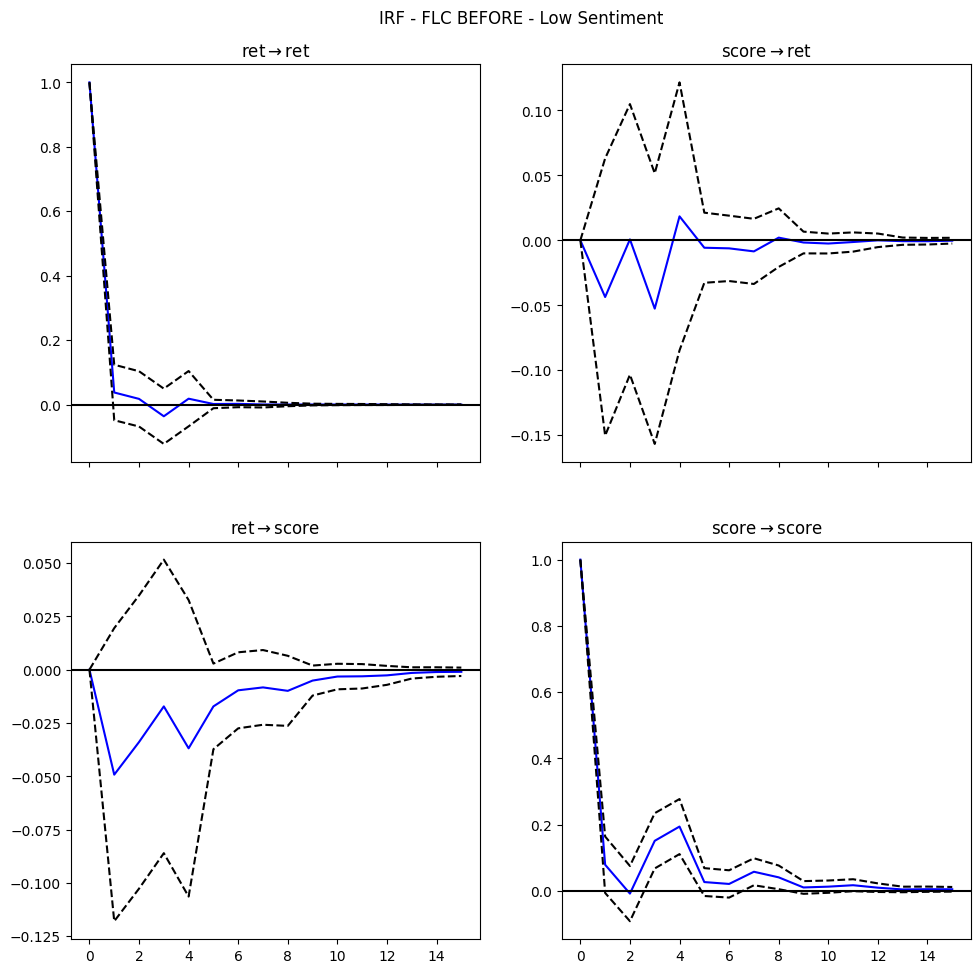

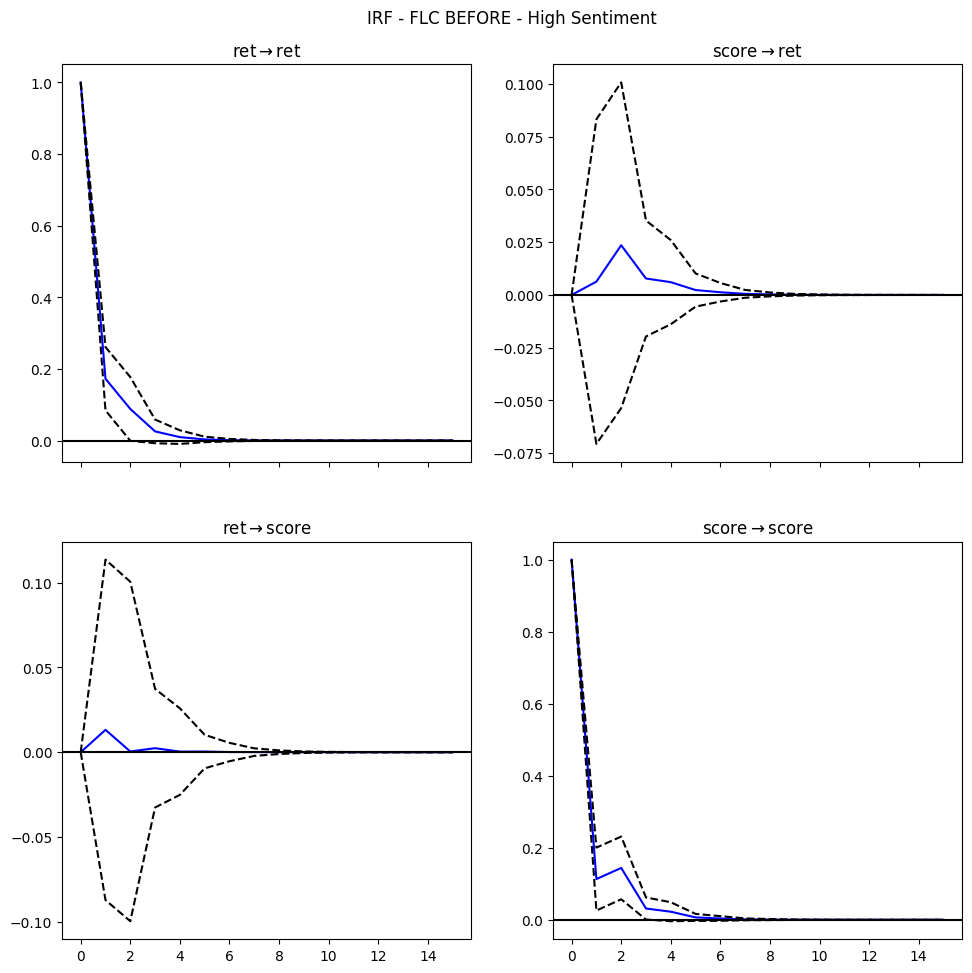


=== GAB (before) ===
Obs Low: 391 | Obs High: 275 | Threshold≈-0.118

[Low regime] lag = 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     17:15:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.581521
Nobs:                     387.000    HQIC:                 -0.692628
Log likelihood:          -932.108    FPE:                   0.465047
AIC:                    -0.765634    Det(Omega_mle):        0.444149
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.045474         0.047604            0.955           0.339
L1.ret           0.303596         0.050929            5.961       

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib

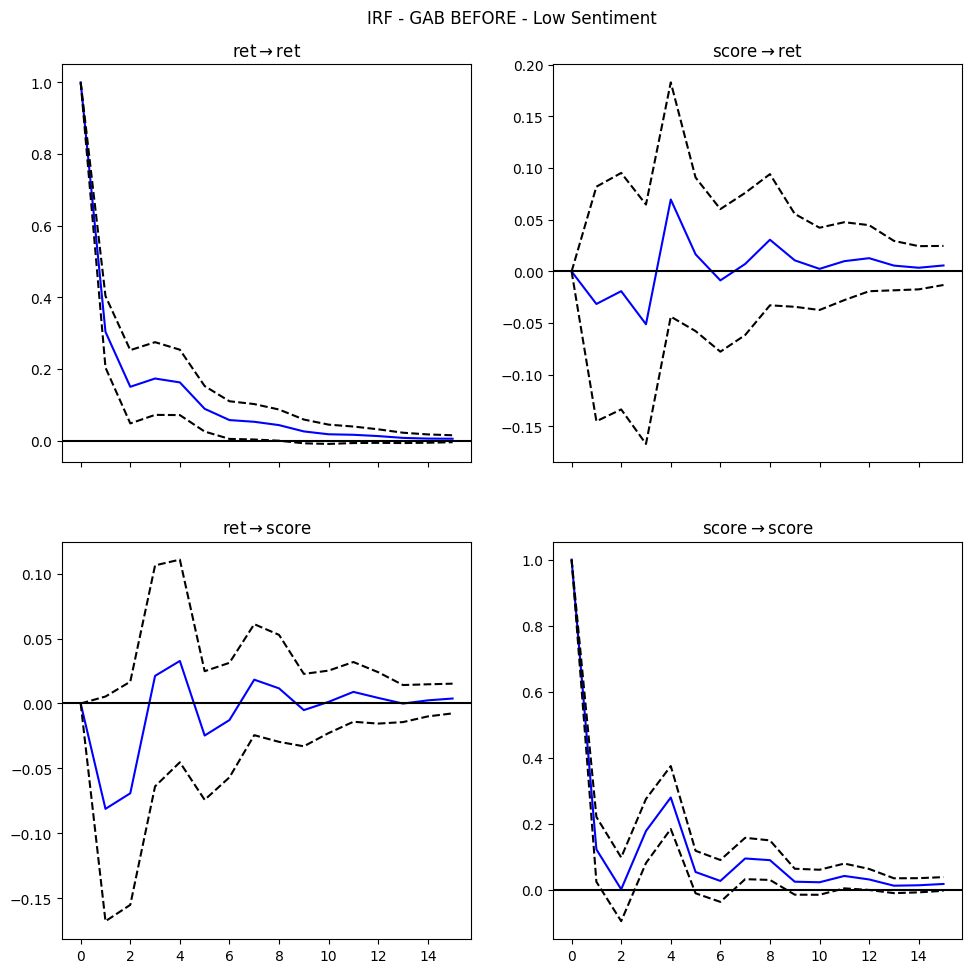

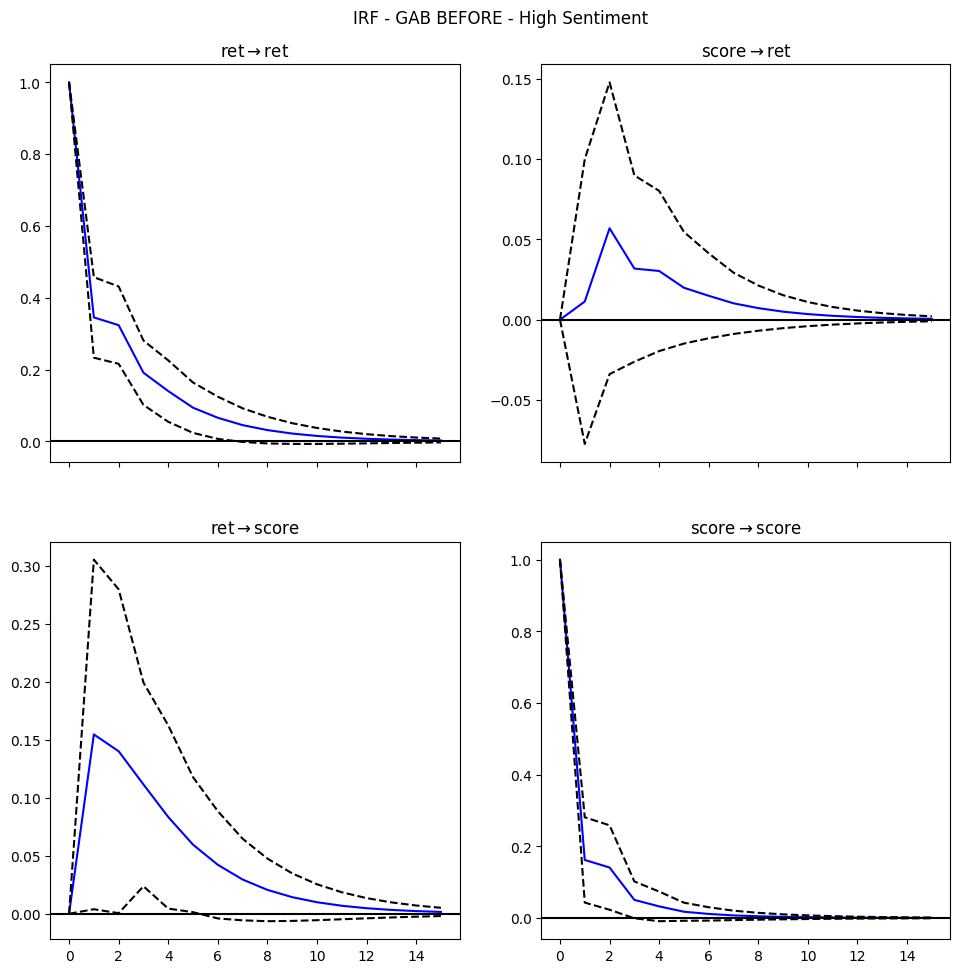


=== HAI (before) ===
Obs Low: 528 | Obs High: 507 | Threshold≈-0.203

[Low regime] lag = 4
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Sep, 2025
Time:                     17:15:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.188603
Nobs:                     524.000    HQIC:                 -0.277663
Log likelihood:          -1381.28    FPE:                   0.715350
AIC:                    -0.334990    Det(Omega_mle):        0.691396
--------------------------------------------------------------------
Results for equation ret
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.007615         0.047318            0.161           0.872
L1.ret           0.030022         0.044047            0.682       

c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\HELLO\AppData\Local\Programs\Python\Python312\Lib

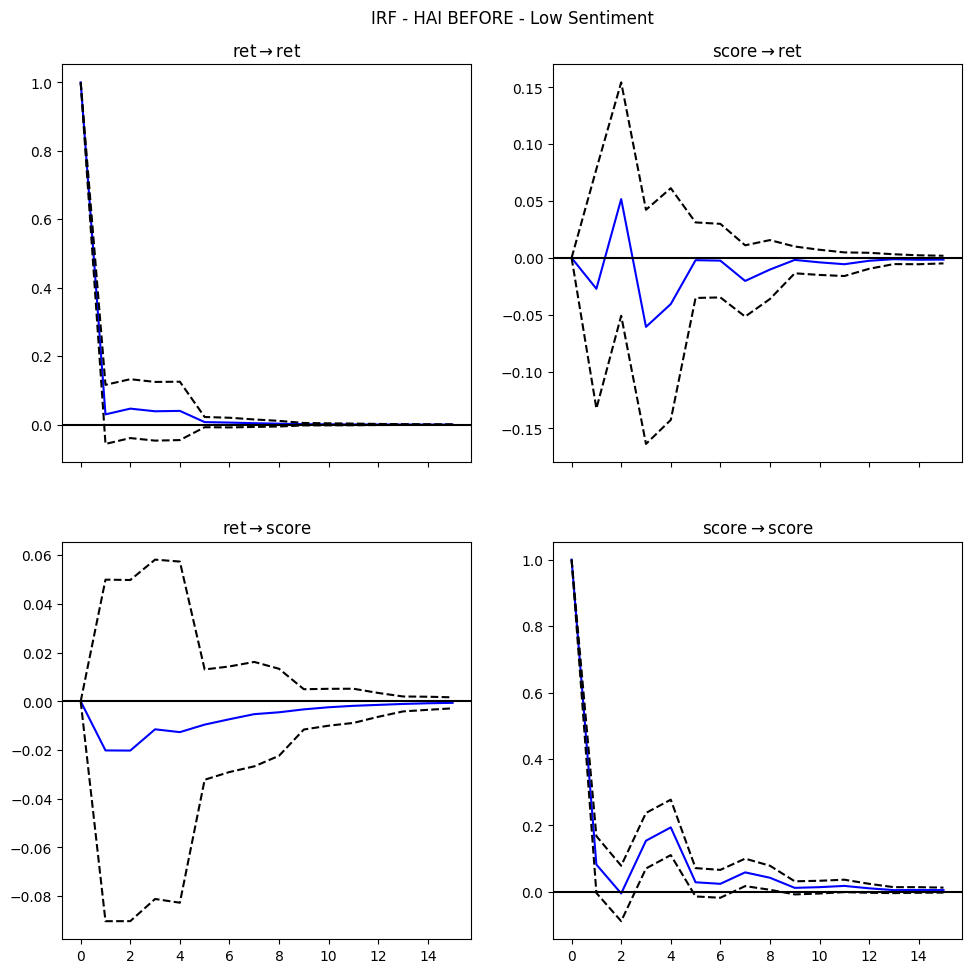

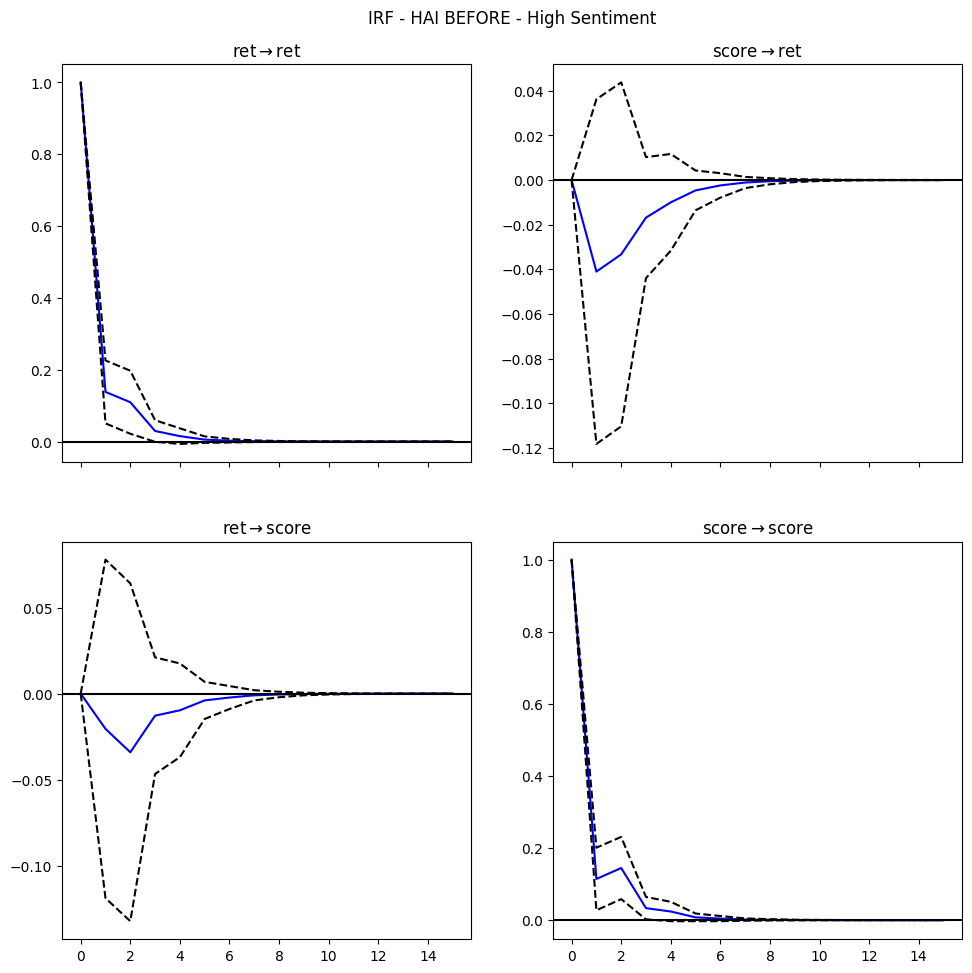

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name=""):
    result = adfuller(series.dropna())
    print(f"ADF p-value for {name}: {result[1]:.4f}")
    if result[1] < 0.05:
        print(f"{name} is likely stationary.")
    else:
        print(f"{name} is likely non-stationary.")

# -------- config ----------
folder_before = r"D:/NCKH/vnecon_before_scandals"
out_dir = os.path.join(folder_before, "_results_before")
os.makedirs(out_dir, exist_ok=True)

def zscore(df):
    return (df - df.mean()) / df.std(ddof=0)

def pick_lag(endog, maxcaps=4):
    n = len(endog)
    maxlags = min(maxcaps, max(1, n // 25))  # n≈200 -> max 4
    try:
        sel = VAR(endog).select_order(maxlags)
        lag = sel.selected_orders.get("aic") or 1
    except Exception:
        lag = 1
    return int(max(1, min(lag, maxlags)))

def fit_var(endog):
    # bỏ regime nếu biến gần hằng số
    if (endog.var() < 1e-10).any():
        raise ValueError("Near-constant series; skip.")
    p = pick_lag(endog)
    try:
        return VAR(endog).fit(p)
    except np.linalg.LinAlgError:
        # jitter phá suy biến
        jitter = endog + np.random.normal(scale=1e-6, size=endog.shape)
        return VAR(jitter).fit(p)

def plot_irf_save(irf, title, save_path, orth=False):
    fig = irf.plot(orth=orth)   # trả về Figure
    plt.suptitle(title)
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def run_before(path, ticker):
    df = pd.read_excel(path).sort_values("date")

    # return & continuous score
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["ret"]   = np.log(df["close"].replace(0, np.nan)).diff()
    df["score"] = pd.to_numeric(df.get("Tích cực"), errors="coerce") \
                - pd.to_numeric(df.get("Tiêu cực"), errors="coerce")

    data = df[["ret","score"]].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) < 30:
        print(f"{ticker}: observations too small ({len(data)}). Skipped.")
        return

    # Ví dụ kiểm tra trước khi fit VAR
    check_stationarity(data['ret'], "Return")
    check_stationarity(data['score'], "Score")

    Z = zscore(data)
    thr = Z["score"].median()
    low  = Z[Z["score"].shift(1) <= thr].dropna()
    high = Z[Z["score"].shift(1) >  thr].dropna()

    print(f"\n=== {ticker} (before) ===")
    print(f"Obs Low: {len(low)} | Obs High: {len(high)} | Threshold≈{thr: .3f}")

    # fit từng regime
    res_low = res_high = None
    try:
        low = low.reset_index(drop=True)
        high = high.reset_index(drop=True)
        res_low = fit_var(low)
        print("\n[Low regime] lag =", res_low.k_ar)
        print(res_low.summary())
    except Exception as e:
        print("Low regime failed:", e)

    try:
        res_high = fit_var(high)
        print("\n[High regime] lag =", res_high.k_ar)
        print(res_high.summary())
    except Exception as e:
        print("High regime failed:", e)

    # IRF (orth=False để không cần Cholesky PD)
    if res_low is not None:
        try:
            irf_l = res_low.irf(15)
            plot_irf_save(
                irf_l,
                f"IRF - {ticker} BEFORE - Low Sentiment",
                os.path.join(out_dir, f"{ticker}_BEFORE_IRF_low.png"),
                orth=False
            )
        except Exception as e:
            print("IRF Low failed:", e)

    if res_high is not None:
        try:
            irf_h = res_high.irf(15)
            plot_irf_save(
                irf_h,
                f"IRF - {ticker} BEFORE - High Sentiment",
                os.path.join(out_dir, f"{ticker}_BEFORE_IRF_high.png"),
                orth=False
            )
        except Exception as e:
            print("IRF High failed:", e)

# -------- run all before files ----------
files = glob.glob(os.path.join(folder_before, "*.xlsx"))
if not files:
    print("Không thấy .xlsx trong:", folder_before)

for f in files:
    ticker = os.path.splitext(os.path.basename(f))[0]
    run_before(f, ticker)


In [1]:
import os, glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

# ===== config =====
folder_after = r"D:/NCKH/vnecon_after_scandals"
out_dir = os.path.join(folder_after, "_results_after")
os.makedirs(out_dir, exist_ok=True)

# Seed để tái lập (đặc biệt khi dùng jitter)
np.random.seed(42)

# Ngưỡng nhận diện chuỗi (gần) hằng số — dùng thống nhất khắp nơi
TOL_CONST = 1e-10

# ===== utils =====
def zscore(df: pd.DataFrame) -> pd.DataFrame:
    return (df - df.mean()) / df.std(ddof=0)

def pick_lag(endog: pd.DataFrame, maxcaps: int = 8) -> int:
    """
    Chọn bậc trễ tối ưu theo BIC (fallback AIC), với trần mềm tay hơn:
    p_max = min(maxcaps, sqrt(n)). Thực tế giúp tránh p=1 quá thường xuyên.
    """
    n = len(endog)
    heuristic = max(1, int(np.sqrt(n)))
    maxlags = min(maxcaps, heuristic)
    try:
        sel = VAR(endog).select_order(maxlags)
        lag = sel.selected_orders.get("bic") or sel.selected_orders.get("aic") or 1
    except Exception:
        lag = 1
    return int(max(1, min(lag, maxlags)))

def fit_var(endog: pd.DataFrame):
    # Bỏ nếu có biến gần hằng số
    if (endog.var() < TOL_CONST).any():
        raise ValueError("Near-constant series; skip.")
    p = pick_lag(endog)
    try:
        return VAR(endog).fit(p)
    except np.linalg.LinAlgError:
        # jitter phá suy biến
        jitter = endog + np.random.normal(scale=1e-6, size=endog.shape)
        return VAR(jitter).fit(p)

def _is_constant(x: pd.Series, tol=TOL_CONST) -> bool:
    x = pd.Series(x).dropna()
    if len(x) == 0:
        return True
    return float(x.var()) < tol or x.nunique() <= 1

def adf_test(x, regression: str = "c"):
    """ADF: H0 = có unit root (không dừng)."""
    x = pd.Series(x).dropna()
    if _is_constant(x):
        # Chuỗi hằng số — coi như dừng: ADF p=0
        return {"stat": np.nan, "pvalue": 0.0, "lags": 0, "nobs": len(x)}
    if len(x) < 10:
        return {"stat": np.nan, "pvalue": 1.0, "lags": np.nan, "nobs": len(x)}
    res = adfuller(x, regression=regression, autolag="AIC")
    return {"stat": res[0], "pvalue": res[1], "lags": res[2], "nobs": res[3]}

def kpss_test(x, regression: str = "c", nlags: str = "auto"):
    """KPSS: H0 = dừng (level/trend-stationary)."""
    x = pd.Series(x).dropna()
    if _is_constant(x):
        # Chuỗi hằng số — coi như dừng: KPSS p=1
        return {"stat": np.nan, "pvalue": 1.0, "lags": 0}
    if len(x) < 10:
        return {"stat": np.nan, "pvalue": 0.0, "lags": np.nan}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            stat, pval, lags, _ = kpss(x, regression=regression, nlags=nlags)
        except Exception:
            stat, pval, lags = np.nan, 0.0, np.nan
    return {"stat": stat, "pvalue": pval, "lags": lags}

def stationarity_report(df: pd.DataFrame, level_reg: str = "c") -> pd.DataFrame:
    """In bảng ADF/KPSS cho từng biến."""
    print("\n[Stationarity checks]")
    rows = []
    for col in df.columns:
        a = adf_test(df[col], regression=level_reg)
        k = kpss_test(df[col], regression=level_reg)
        rows.append({
            "var": col,
            "ADF_p": a["pvalue"],
            "KPSS_p": k["pvalue"],
            "ADF_stat": a["stat"],
            "KPSS_stat": k["stat"],
            "ADF_lags": a["lags"],
            "KPSS_lags": k["lags"],
            "nobs": a.get("nobs", len(df[col].dropna()))
        })
    rep = pd.DataFrame(rows)
    print(rep.to_string(index=False))
    return rep

def make_stationary(
    df: pd.DataFrame, max_d: int = 2, level_reg: str = "c",
    alpha: float = 0.05, alpha_kpss: float | None = None
):
    """
    Difference từng biến tối đa max_d lần cho tới khi:
      - ADF p < alpha, và
      - KPSS p >= alpha_kpss (mặc định = alpha; có thể set 0.06 để an toàn biên).
    """
    if alpha_kpss is None:
        alpha_kpss = alpha

    df_out = df.copy()
    diffs = {c: 0 for c in df.columns}

    for col in df.columns:
        series = df_out[col].copy()
        d = 0
        while d <= max_d:
            a = adf_test(series, regression=level_reg)
            k = kpss_test(series, regression=level_reg)
            if (a["pvalue"] < alpha) and (k["pvalue"] >= alpha_kpss):
                break
            if d == max_d:
                print(f"⚠️  {col}: chưa đạt ADF&KPSS sau {max_d} lần diff; dùng D^{d}{col}.")
                break
            series = series.diff().dropna()
            d += 1

        df_out[col] = series
        diffs[col] = d

    df_out = df_out.dropna().copy()

    print("\n[Applied differences]")
    for c, d in diffs.items():
        print(f"  {c}: diff {d} time(s)")

    report = stationarity_report(df_out, level_reg=level_reg)
    return df_out, diffs, report

def plot_irf_save(irf, title: str, save_path: str, orth: bool = False):
    obj = irf.plot(orth=orth)
    fig = obj if hasattr(obj, "savefig") else plt.gcf()
    plt.suptitle(title)
    fig.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

def diag_var(label: str, res):
    """Chẩn đoán ổn định & tự tương quan phần dư (tùy chọn)."""
    try:
        stable = res.is_stable()
        max_root = np.max(np.abs(res.roots))
        print(f"\n[Diag {label}] Stable? {stable} | Max root = {max_root:.3f}")
        for col in res.resid.columns:
            lb = acorr_ljungbox(res.resid[col], lags=[10], return_df=True)
            p10 = float(lb["lb_pvalue"].iloc[0])
            print(f"Ljung-Box({col}, lag10) p = {p10:.3f}")
    except Exception as e:
        print(f"Diag failed ({label}):", e)

# ===== core pipeline =====
def run_after(path: str, ticker: str):
    # Đọc Excel robust hơn
    df = pd.read_excel(path, engine="openpyxl")
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.sort_values("date")
    else:
        df = df.sort_index()

    # return & continuous score
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["ret"] = np.log(df["close"].replace(0, np.nan)).diff()

    # score = tích cực - tiêu cực
    df["score"] = (
        pd.to_numeric(df.get("Tích cực"), errors="coerce")
        - pd.to_numeric(df.get("Tiêu cực"), errors="coerce")
    )

    data = df[["ret", "score"]].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) < 30:
        print(f"{ticker}: observations too small ({len(data)}). Skipped.")
        return

    # Loại nếu có biến gần hằng số
    if (data.var() < TOL_CONST).any():
        bad_cols = [c for c in data.columns if float(data[c].var()) < TOL_CONST]
        print(f"{ticker}: near-constant series in {bad_cols}. Skipped.")
        return

    # Kiểm định & làm dừng
    data_stationary, diffs, rep = make_stationary(
        data, max_d=2, level_reg="c", alpha=0.05, alpha_kpss=0.06
    )
    if len(data_stationary) < 30:
        print(f"{ticker}: observations too small after differencing ({len(data_stationary)}). Skipped.")
        return

    # Z-score & chia regime theo median(score) tại t-1
    Z = zscore(data_stationary)
    thr = Z["score"].median()
    low  = Z[Z["score"].shift(1) <= thr].dropna().reset_index(drop=True)
    high = Z[Z["score"].shift(1) >  thr].dropna().reset_index(drop=True)

    print(f"\n=== {ticker} (AFTER) ===")
    print(f"Obs Low: {len(low)} | Obs High: {len(high)} | Threshold≈{thr: .3f}")

    # Fit từng regime
    res_low = res_high = None
    try:
        res_low = fit_var(low)
        print("\n[Low regime] lag =", res_low.k_ar)
        print(res_low.summary())
        diag_var("LOW", res_low)
    except Exception as e:
        print("Low regime failed:", e)

    try:
        res_high = fit_var(high)
        print("\n[High regime] lag =", res_high.k_ar)
        print(res_high.summary())
        diag_var("HIGH", res_high)
    except Exception as e:
        print("High regime failed:", e)

    # IRF
    if res_low is not None:
        try:
            irf_l = res_low.irf(15)
            plot_irf_save(
                irf_l,
                f"IRF - {ticker} AFTER - Low Sentiment",
                os.path.join(out_dir, f"{ticker}_AFTER_IRF_low.png"),
                orth=False
            )
        except Exception as e:
            print("IRF Low failed:", e)

    if res_high is not None:
        try:
            irf_h = res_high.irf(15)
            plot_irf_save(
                irf_h,
                f"IRF - {ticker} AFTER - High Sentiment",
                os.path.join(out_dir, f"{ticker}_AFTER_IRF_high.png"),
                orth=False
            )
        except Exception as e:
            print("IRF High failed:", e)

# ===== run all =====
if __name__ == "__main__":
    files = glob.glob(os.path.join(folder_after, "*.xlsx"))
    if not files:
        print("Không thấy .xlsx trong:", folder_after)

    for f in files:
        ticker = os.path.splitext(os.path.basename(f))[0]
        run_after(f, ticker)



[Applied differences]
  ret: diff 0 time(s)
  score: diff 1 time(s)

[Stationarity checks]
  var        ADF_p  KPSS_p   ADF_stat  KPSS_stat  ADF_lags  KPSS_lags  nobs
  ret 1.170759e-25     0.1 -13.724552   0.303931         1          3   422
score 2.234800e-12     0.1  -8.008439   0.128368        17         94   406

=== AMD (AFTER) ===
Obs Low: 212 | Obs High: 211 | Threshold≈-0.024

[Low regime] lag = 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 01, Oct, 2025
Time:                     23:06:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0663817
Nobs:                     211.000    HQIC:                 -0.123168
Log likelihood:          -575.733    FPE:                   0.850704
AIC:                    -0.161695    Det(Omega_mle):        0.827019
--------------------------------------------------------------------
